In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [2] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 42.387 MiB


# Ideal Point Estimation

Here we perform Ideal Point Estimation of legislators in 113th Congress.

## Load Data
### Legislators
First we have to load in all legislators (this is for all of time, from GovTrack).

In [3]:
import ideal_point.raw_data

In [3] used 33.363 MiB RAM in 1.596s, peaked 0.000 MiB above current, total RAM usage 75.750 MiB


In [5]:
legislator_df = ideal_point.raw_data.legislators()
legislator_df.head()

,last_name,first_name,birthday,gender,type,state,district,party,url,address,...,thomas_id,opensecrets_id,lis_id,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id
0,Brown,Sherrod,1952-11-09,M,sen,OH,NaN,Democrat,https://www.brown.senate.gov,713 Hart Senate Office Building Washington DC ...,...,136.0,N00003535,S307,5051.0,400050,27018.0,Sherrod Brown,NaN,29389.0,Sherrod Brown
1,Cantwell,Maria,1958-10-13,F,sen,WA,NaN,Democrat,https://www.cantwell.senate.gov,511 Hart Senate Office Building Washington DC ...,...,172.0,N00007836,S275,26137.0,300018,27122.0,Maria Cantwell,NaN,39310.0,Maria Cantwell
2,Cardin,Benjamin,1943-10-05,M,sen,MD,NaN,Democrat,https://www.cardin.senate.gov,509 Hart Senate Office Building Washington DC ...,...,174.0,N00001955,S308,4004.0,400064,26888.0,Ben Cardin,NaN,15408.0,Ben Cardin
3,Carper,Thomas,1947-01-23,M,sen,DE,NaN,Democrat,http://www.carper.senate.gov,513 Hart Senate Office Building Washington DC ...,...,179.0,N00012508,S277,663.0,300019,22421.0,Tom Carper,NaN,15015.0,Tom Carper
4,Casey,Robert,1960-04-13,M,sen,PA,NaN,Democrat,https://www.casey.senate.gov,393 Russell Senate Office Building Washington ...,...,1828.0,N00027503,S309,47036.0,412246,2541.0,"Bob Casey, Jr.",NaN,40703.0,Bob Casey Jr.


In [5] used 9.363 MiB RAM in 0.380s, peaked 2.520 MiB above current, total RAM usage 85.973 MiB


### Votes

Next we can load in all the votes. We get two dataframes from this, `vote_df` and `position_df`.

Each row of `vote_df` corresponds to one roll call vote (like on the passage of a bill).

Each row of `position_df` corresponds to one legislators position on a vote.

In [50]:
vote_df, position_df = ideal_point.raw_data.votes(legislator_df)


In [50] used 30.660 MiB RAM in 39.590s, peaked 0.000 MiB above current, total RAM usage 532.789 MiB


In [51]:
vote_df.head()

,amendment_author,amendment_number,amendment_purpose,amendment_type,bill_congress,bill_number,bill_title,bill_type,category,chamber,...,record_modified,requires,result,result_text,session,source_url,subject,type,updated_at,vote_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,quorum,h,...,NaN,QUORUM,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll001.xml,NaN,Call of the House,2014-06-18T11:22:24-04:00,h1-113.2013
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,procedural,h,...,NaN,1/2,Failed,Failed,2013,http://clerk.house.gov/evs/2013/roll010.xml,NaN,On the Motion to Adjourn,2014-06-18T11:22:23-04:00,h10-113.2013
2,NaN,NaN,NaN,NaN,113.0,1120.0,NaN,hr,recommit,h,...,NaN,1/2,Failed,Failed,2013,http://clerk.house.gov/evs/2013/roll100.xml,Preventing Greater Uncertainty in Labor-Manage...,On the Motion to Recommit,2014-06-18T11:22:04-04:00,h100-113.2013
3,NaN,NaN,NaN,NaN,113.0,1120.0,NaN,hr,passage,h,...,NaN,1/2,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll101.xml,Preventing Greater Uncertainty in Labor-Manage...,On Passage of the Bill,2014-06-18T11:22:04-04:00,h101-113.2013
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,procedural,h,...,NaN,1/2,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll102.xml,NaN,On Approving the Journal,2014-06-18T11:22:04-04:00,h102-113.2013


In [51] used 0.094 MiB RAM in 0.056s, peaked 0.000 MiB above current, total RAM usage 532.883 MiB


In [7]:
position_df.head()

,legislator_index,position,vote_index
0,39,Present,0
1,12270,Present,0
2,40,Present,0
3,376,Present,0
4,12276,Present,0


In [7] used 0.000 MiB RAM in 0.017s, peaked 0.000 MiB above current, total RAM usage 281.953 MiB


## Transform Data

Next we have to transform our data to a format we can train our model on.

Our observed data is basically `position_df`. but instead of categorical `position`s, we need them to
be 1s and 0s. Also, since we aren't using all of the legislators, we need to transform
the `legislator_index` into a relative index. We call this transformed dataframe `model_position_df`.

In [52]:
import ideal_point.ideal_point

In [52] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 532.883 MiB


In [54]:
model_position_df, model_legislator_index, model_vote_index = ideal_point.ideal_point.transform_data(position_df, vote_df, legislator_df)

In [54] used 61.922 MiB RAM in 1.850s, peaked 0.090 MiB above current, total RAM usage 684.652 MiB


In [43]:
model_position_df.head()

,legislator,position,vote
0,39,0,0
1,530,0,0
2,40,0,0
3,375,0,0
4,0,0,0


In [43] used 0.000 MiB RAM in 0.010s, peaked 0.000 MiB above current, total RAM usage 832.270 MiB


In [55]:
model_position_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508555 entries, 0 to 508554
Data columns (total 3 columns):
legislator    508555 non-null int64
position      508555 non-null int64
vote          508555 non-null int64
dtypes: int64(3)
memory usage: 11.6 MB
In [55] used 0.000 MiB RAM in 0.014s, peaked 0.000 MiB above current, total RAM usage 684.652 MiB


The two series `model_legislator_index` and `model_vote_index` map the values in `model_position_df` to the full dataframes, from index to value.

## Create Model

Now we can create our model, given we have observed those votes. The notation is based
on ["Comparing NOMINATE and IDEAL: Points of Difference and Monte Carlo Tests"](http://scholar-qa.princeton.edu/sites/default/files/jameslo/files/lsq_nomvsideal.pdf).

In [57]:
model = ideal_point.ideal_point.create_model(model_position_df)

In [57] used 15.957 MiB RAM in 0.330s, peaked 0.000 MiB above current, total RAM usage 700.609 MiB


## Train Model

Now we can run variational inference to compute estimated parameters for the model.

In [58]:
advi_params = ideal_point.ideal_point.advi_params(model)
ideal_point.ideal_point.save_advi_params(advi_params)

Iteration 0 [0%]: ELBO = -456288.87
Iteration 2500 [10%]: Average ELBO = -391322.53
Iteration 5000 [20%]: Average ELBO = -322712.87
Iteration 7500 [30%]: Average ELBO = -233113.28
Iteration 10000 [40%]: Average ELBO = -126637.24
Iteration 12500 [50%]: Average ELBO = -90822.03
Iteration 15000 [60%]: Average ELBO = -84521.04
Iteration 17500 [70%]: Average ELBO = -83370.08
Iteration 20000 [80%]: Average ELBO = -83124.26
Iteration 22500 [90%]: Average ELBO = -83043.98
Finished [100%]: Average ELBO = -83008.52
In [58] used 57.559 MiB RAM in 5421.597s, peaked 89.910 MiB above current, total RAM usage 758.168 MiB


Or load it from disk, if we have already computed it (takes about an hour and a half on my computer)

In [27]:
#advi_params = ideal_point.ideal_point.load_advi_params()

In [27] used 0.145 MiB RAM in 0.027s, peaked 0.000 MiB above current, total RAM usage 495.988 MiB


## Integrate Data

Now we can integrate the parameters we learned backed info our `vote_df` and `legislator_df`. We add a `ideology` column to both of them and filter out rows without ideal points. We also add a `bias` to the votes (which is greater if any senator is more likely to vote yes).

In [62]:
legislators_pt_df = ideal_point.ideal_point.leg_add_ideology(legislator_df, model_legislator_index, advi_params)
vote_pt_df = ideal_point.ideal_point.vote_add_ideology_and_bias(vote_df, model_vote_index, advi_params)

In [62] used 0.000 MiB RAM in 0.026s, peaked 0.000 MiB above current, total RAM usage 758.168 MiB


### Visualize Points

We can do a quick gut chuck of our legislator ideal points to make sure they seperate democrats and republicans

In [63]:
from altair import *

In [63] used 0.059 MiB RAM in 0.182s, peaked 0.000 MiB above current, total RAM usage 758.227 MiB


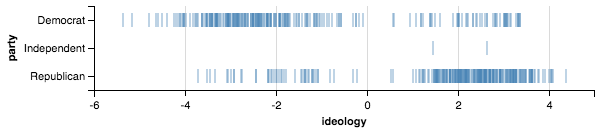

In [67] used 0.000 MiB RAM in 0.141s, peaked 0.000 MiB above current, total RAM usage 758.227 MiB


In [67]:
Chart(legislators_pt_df).mark_tick().encode(
    x='ideology:Q',
    y='party:O',
)

In [69]:
legislators_pt_df.sort_values(by=["ideology"])

,last_name,first_name,birthday,gender,type,state,district,party,url,address,...,opensecrets_id,lis_id,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id,ideology
312,Schakowsky,Janice,1944-05-26,F,rep,IL,9.0,Democrat,http://schakowsky.house.gov,2367 Rayburn HOB; Washington DC 20515-1309,...,N00004724,NaN,57874.0,400360,6387.0,Jan Schakowsky,NaN,29911.0,Jan Schakowsky,-5.355797
457,Pocan,Mark,1964-08-14,M,rep,WI,2.0,Democrat,http://pocan.house.gov,313 Cannon HOB; Washington DC 20515-4902,...,N00033549,NaN,79688.0,412585,26238.0,Mark Pocan,NaN,21370.0,Mark Pocan,-5.154910
235,McGovern,James,1959-11-20,M,rep,MA,2.0,Democrat,http://mcgovern.house.gov,438 Cannon HOB; Washington DC 20515-2102,...,N00000179,NaN,45976.0,400263,552.0,NaN,NaN,29729.0,Jim McGovern (U.S. politician),-4.787142
253,Nadler,Jerrold,1947-06-13,M,rep,NY,10.0,Democrat,http://nadler.house.gov,2109 Rayburn HOB; Washington DC 20515-3210,...,N00000939,NaN,26159.0,400289,26980.0,NaN,NaN,29377.0,Jerrold Nadler,-4.644795
120,Edwards,Donna,1958-06-28,F,rep,MD,4.0,Democrat,http://donnaedwards.house.gov,2445 Rayburn HOB; Washington DC 20515-2004,...,N00028249,NaN,38535.0,412263,65085.0,NaN,NaN,20763.0,Donna Edwards,-4.582843
209,Lee,Barbara,1946-07-16,F,rep,CA,13.0,Democrat,http://lee.house.gov,2267 Rayburn HOB; Washington DC 20515-0513,...,N00008046,NaN,54579.0,400237,8315.0,NaN,NaN,29778.0,Barbara Lee,-4.510990
46,Becerra,Xavier,1958-01-26,M,rep,CA,34.0,Democrat,http://becerra.house.gov,1226 Longworth HOB; Washington DC 20515-0534,...,N00009774,NaN,26567.0,400021,26754.0,Xavier Becerra,NaN,29316.0,Xavier Becerra,-4.403183
322,Serrano,José,1943-10-24,M,rep,NY,15.0,Democrat,http://serrano.house.gov,2227 Rayburn HOB; Washington DC 20515-3215,...,N00001813,NaN,14306.0,400366,26981.0,NaN,NaN,29134.0,José E. Serrano,-4.229245
12305,Holt,Rush,1948-10-15,M,rep,NJ,12.0,Democrat,http://holt.house.gov,1214 Longworth HOB; Washington DC 20515-3012,...,N00000860,NaN,57967.0,400184,22574.0,NaN,NaN,29923.0,Rush D. Holt Jr.,-4.192777
121,Ellison,Keith,1963-08-04,M,rep,MN,5.0,Democrat,http://ellison.house.gov,2263 Rayburn HOB; Washington DC 20515-2305,...,N00028257,NaN,1022556.0,412215,38982.0,Keith Ellison,NaN,20727.0,Keith Ellison,-4.156979


In [69] used 0.000 MiB RAM in 0.150s, peaked 0.000 MiB above current, total RAM usage 758.227 MiB


### Validation

Some of the most conservative members in our model include Mike Pompeo, who lead the house inquiry into Benghazi, and Randy Weber, who drew fire for a tweet declaring Barack Obama a "socialist dictator."

Some of the most liberal members include Jim McGovern, who represents the pioneer valley and Jerrold Nadler, who represents Manhattan's upper west side. The most liberal legislator, Jan Schakowsky, is a longtime critic of the Iraq war.

The house bills to remove voted on by all democrats are close to the democratic ideology.

In [70]:
r = vote_pt_df[vote_pt_df["question"].str.contains("To repeal the Patient Protection ")]
r

,amendment_author,amendment_number,amendment_purpose,amendment_type,bill_congress,bill_number,bill_title,bill_type,category,chamber,...,result,result_text,session,source_url,subject,type,updated_at,vote_id,bias,ideology
60,NaN,NaN,NaN,NaN,113.0,45.0,NaN,hr,recommit,h,...,Failed,Failed,2013,http://clerk.house.gov/evs/2013/roll153.xml,To repeal the Patient Protection and Affordabl...,On the Motion to Recommit,2014-06-18T11:21:59-04:00,h153-113.2013,-2.861397,-2.861397
61,NaN,NaN,NaN,NaN,113.0,45.0,NaN,hr,passage,h,...,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll154.xml,To repeal the Patient Protection and Affordabl...,On Passage of the Bill,2014-06-18T11:21:59-04:00,h154-113.2013,3.141166,3.141166


In [70] used 0.000 MiB RAM in 0.052s, peaked 0.000 MiB above current, total RAM usage 758.227 MiB


This is to get bills linked w/ duplication data for now

In [72]:

vote_pt_df.sort_values("bias", ascending=False)

,amendment_author,amendment_number,amendment_purpose,amendment_type,bill_congress,bill_number,bill_title,bill_type,category,chamber,...,result,result_text,session,source_url,subject,type,updated_at,vote_id,bias,ideology
1400,NaN,NaN,NaN,NaN,113.0,756.0,NaN,hres,procedural,h,...,Passed,Passed,2014,http://clerk.house.gov/evs/2014/roll521.xml,Providing for consideration of the bill (H.R. ...,On Ordering the Previous Question,2014-11-21T13:15:15-05:00,h521-113.2014,3.237360,3.237360
96,NaN,NaN,NaN,NaN,113.0,243.0,NaN,hres,procedural,h,...,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll186.xml,"Providing for consideration of H.R. 2216, the ...",On Ordering the Previous Question,2014-06-18T11:21:56-04:00,h186-113.2013,3.232522,3.232522
1401,NaN,NaN,NaN,NaN,113.0,756.0,NaN,hres,passage,h,...,Passed,Passed,2014,http://clerk.house.gov/evs/2014/roll522.xml,Providing for consideration of the bill (H.R. ...,On the Resolution,2014-11-21T13:15:15-05:00,h522-113.2014,3.231046,3.231046
1337,NaN,NaN,NaN,NaN,113.0,694.0,NaN,hres,procedural,h,...,Passed,Passed,2014,http://clerk.house.gov/evs/2014/roll465.xml,"Providing for consideration of H.Res. 676, pro...",On Ordering the Previous Question,2014-08-02T15:58:47-04:00,h465-113.2014,3.229739,3.229739
1306,NaN,NaN,NaN,NaN,113.0,677.0,NaN,hres,procedural,h,...,Passed,Passed,2014,http://clerk.house.gov/evs/2014/roll437.xml,Providing for consideration of the bill (H.R. ...,On Ordering the Previous Question,2014-07-26T12:48:17-04:00,h437-113.2014,3.228667,3.228667
210,NaN,NaN,NaN,NaN,113.0,274.0,NaN,hres,procedural,h,...,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll289.xml,"Providing for consideration of H.R. 1613, Oute...",On Ordering the Previous Question,2014-06-18T11:21:44-04:00,h289-113.2013,3.228001,3.228001
438,NaN,NaN,NaN,NaN,113.0,366.0,NaN,hres,procedural,h,...,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll494.xml,Providing for consideration of the Senate amen...,On Ordering the Previous Question,2014-06-18T11:21:08-04:00,h494-113.2013,3.227057,3.227057
485,NaN,NaN,NaN,NaN,113.0,90.0,NaN,hjres,unknown,h,...,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll536.xml,Making continuing appropriations for the Feder...,Table Appeal of the Ruling of the Chair,2014-06-18T11:20:59-04:00,h536-113.2013,3.225015,3.225015
1329,NaN,NaN,NaN,NaN,113.0,693.0,NaN,hres,procedural,h,...,Passed,Passed,2014,http://clerk.house.gov/evs/2014/roll458.xml,Providing for consideration of the bill (H.R. ...,On Ordering the Previous Question,2014-08-01T13:15:17-04:00,h458-113.2014,3.223474,3.223474
953,NaN,NaN,NaN,NaN,113.0,511.0,NaN,hres,procedural,h,...,Passed,Passed,2014,http://clerk.house.gov/evs/2014/roll118.xml,Providing for consideration of the bill (H.R. ...,On Ordering the Previous Question,2014-06-18T11:23:31-04:00,h118-113.2014,3.222037,3.222037


In [72] used 0.000 MiB RAM in 0.142s, peaked 0.000 MiB above current, total RAM usage 758.227 MiB


In [73]:


vote_pt_df.to_csv("bills_idealpoints.csv", sep='\t')

In [73] used 0.000 MiB RAM in 0.120s, peaked 0.000 MiB above current, total RAM usage 758.227 MiB
